# Telco Customer Churn - Exploratory Data Analysis

**Objective:** Understand the customer churn dataset, identify patterns, and prepare for modeling.

**Data Source:** `data/raw/customer_churn_dataset.xlsx`

**Mindset:** Trust nothing, verify everything. Every analysis should answer: *"How does this help me build a better model?"*


## Setup


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


## 1. Load Data

In [ ]:
# Load the Excel file from raw data
data_path = '../../data/raw/customer_churn_dataset.xlsx'

print(f"Loading data from: {data_path}")
df = pd.read_excel(data_path)

print(f"\n✓ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

# Display first few rows
print("\n=== First 5 Rows ===")
display(df.head())

# Display last few rows
print("\n=== Last 5 Rows ===")
display(df.tail())


Loading data from: ../../data/raw/customer_churn_dataset.xlsx

✓ Dataset loaded successfully!
Shape: (7043, 23)
Rows: 7,043
Columns: 23

=== First 5 Rows ===


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes



=== Last 5 Rows ===


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,0,0,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,0,5,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,0,0,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,2,0,No


## 2. Data Overview

In [ ]:
# Basic info
print("=== Data Types ===")
df.info()

print("\n=== Column Names ===")
print(df.columns.tolist())


=== Data Types ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 

In [8]:
# Statistical summary
df.describe()


,SeniorCitizen,tenure,MonthlyCharges,numAdminTickets,numTechTickets
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.515689,0.419566
std,0.368612,24.559481,30.090047,1.275299,1.250117
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,0.000000,0.000000
75%,0.000000,55.000000,89.850000,0.000000,0.000000
max,1.000000,72.000000,118.750000,5.000000,9.000000


In [9]:
# Categorical summary
print("=== Categorical Features Summary ===")
df.describe(include='object')


=== Categorical Features Summary ===


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


### 2.1 Check for Duplicates


In [10]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"⚠️ Warning: {duplicates} duplicate rows found ({duplicates/len(df)*100:.2f}%)")
    print("\nSample duplicates:")
    display(df[df.duplicated(keep=False)].head(10))
else:
    print("✓ No duplicate rows found")


Duplicate rows: 0
✓ No duplicate rows found


## 3. Data Quality - Missing Values


In [11]:
# Missing values
missing = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing = missing[missing['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing) > 0:
    print("⚠️ Missing Values Found:")
    print(missing)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    missing['Percentage'].plot(kind='barh')
    plt.xlabel('Percentage Missing (%)')
    plt.title('Missing Values by Feature')
    plt.tight_layout()
    plt.show()
else:
    print("✓ No missing values found")


✓ No missing values found


## 4. Target Variable Analysis


Potential churn columns: ['Churn']

=== Target Variable: Churn ===
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: Churn
No     73.46
Yes    26.54
Name: proportion, dtype: float64


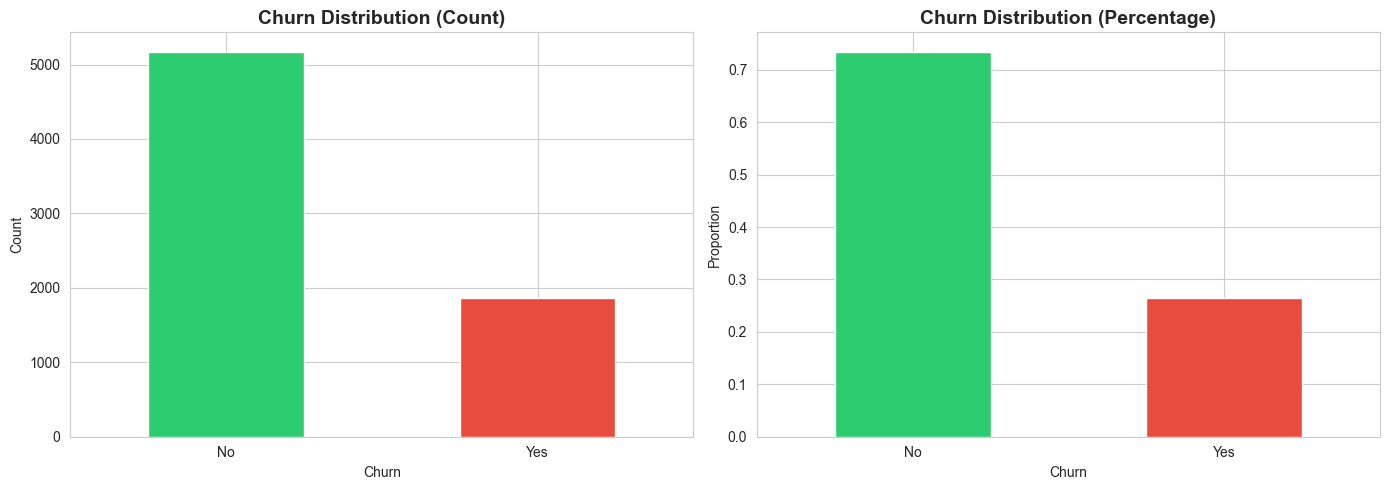

In [12]:
# Identify target column (typically 'Churn', 'Churn Label', etc.)
churn_cols = [col for col in df.columns if 'churn' in col.lower()]
print(f"Potential churn columns: {churn_cols}")

# Set target column - adjust based on your data
target_col = churn_cols[0] if churn_cols else 'Churn'

if target_col in df.columns:
    print(f"\n=== Target Variable: {target_col} ===")
    print(df[target_col].value_counts())
    print(f"\nChurn Rate: {(df[target_col].value_counts(normalize=True) * 100).round(2)}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot
    df[target_col].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
    axes[0].set_title('Churn Distribution (Count)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel(target_col)
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=0)
    
    # Percentage plot
    df[target_col].value_counts(normalize=True).plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
    axes[1].set_title('Churn Distribution (Percentage)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(target_col)
    axes[1].set_ylabel('Proportion')
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ Warning: '{target_col}' column not found. Please identify the target variable.")


### 4.1 Class Balance Check


In [15]:
# Check class balance
if target_col in df.columns:
    value_counts = df[target_col].value_counts()
    percentages = df[target_col].value_counts(normalize=True) * 100
    minority_pct = percentages.min()
    
    print("=== Class Distribution ===")
    for val, count in value_counts.items():
        pct = percentages[val]
        print(f"{val}: {count:,} ({pct:.2f}%)")
    
    # Calculate imbalance ratio
    imbalance_ratio = value_counts.max() / value_counts.min()
    print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
    print(f"Minority Class: {minority_pct:.2f}%")
    
    # Actionable recommendations based on severity
    if imbalance_ratio > 10 or minority_pct < 10:
        print("\n🚨 SEVERE IMBALANCE detected!")
        print("Action: MUST address - Use SMOTE, class weights, or undersampling")
        print("Risk: Model will be heavily biased toward majority class")
    elif imbalance_ratio > 5:
        print("\n⚠️ SIGNIFICANT imbalance detected!")
        print("Action: Strongly recommend SMOTE, class weights, or stratified sampling")
        print("Risk: Model may struggle to learn minority class patterns")
    elif imbalance_ratio > 3:
        print("\n⚠️ MODERATE imbalance detected!")
        print("Action: Consider balancing techniques based on use case")
        print("Note: May work without treatment, but test both approaches")
    else:
        print("\n✓ Classes are reasonably balanced")
        print("Action: Stratified sampling should be sufficient")


=== Class Distribution ===
No: 5,174 (73.46%)
Yes: 1,869 (26.54%)

Imbalance Ratio: 2.77:1
Minority Class: 26.54%

✓ Classes are reasonably balanced
Action: Stratified sampling should be sufficient


## 5. Numerical Features Distribution


Numerical columns (5): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'numAdminTickets', 'numTechTickets']


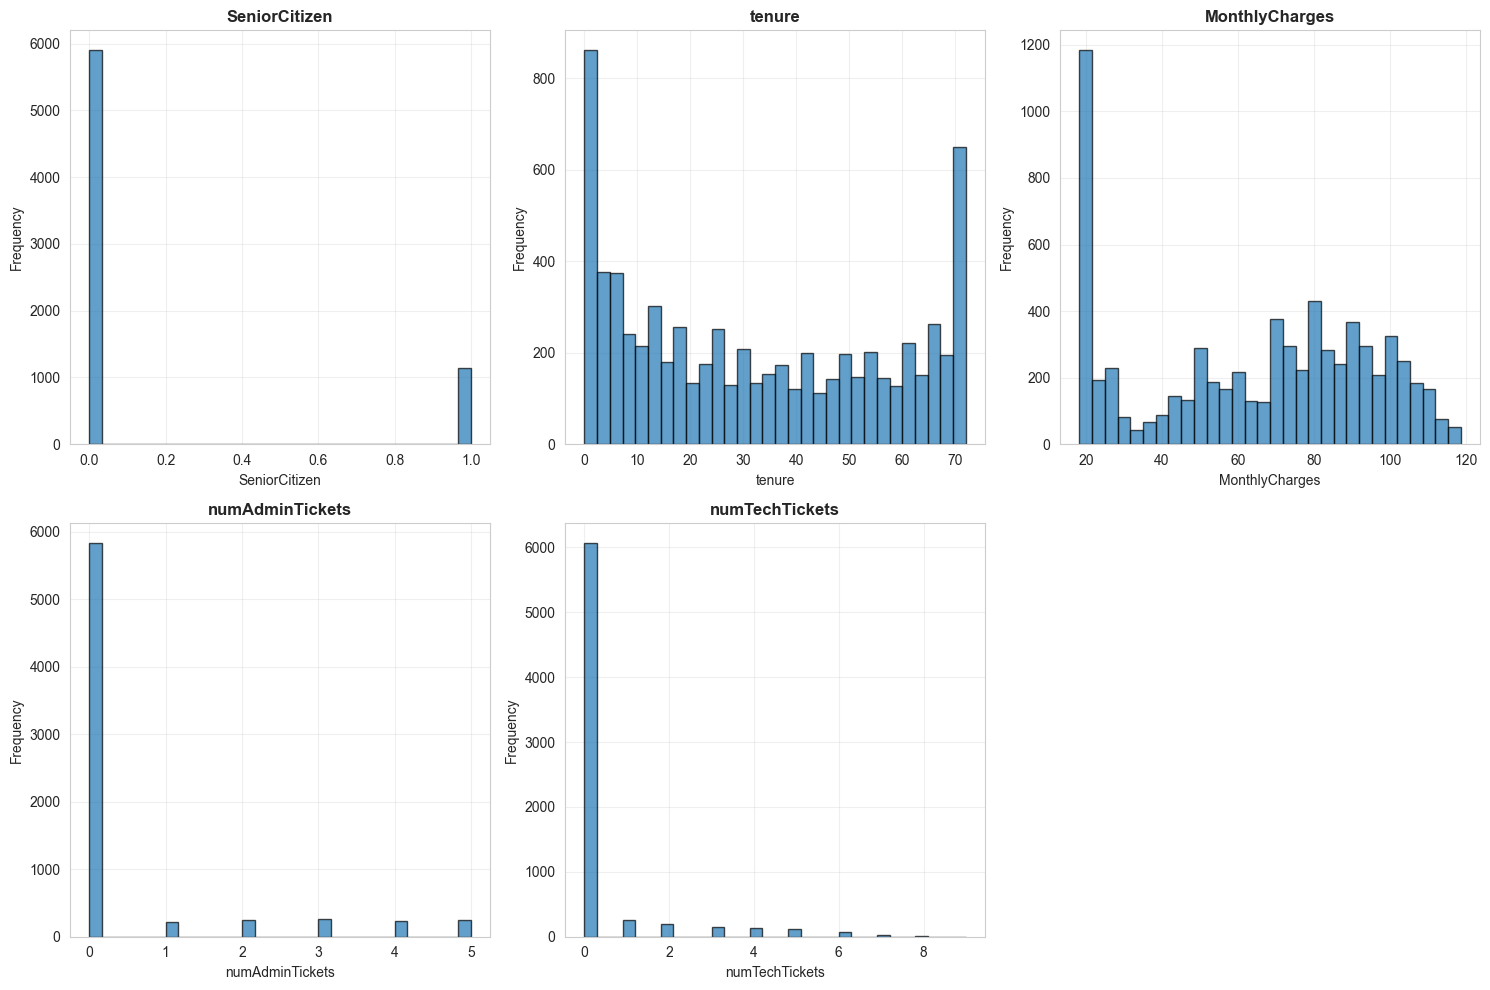

In [16]:
# Get numerical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical columns ({len(numeric_cols)}): {numeric_cols}")

# Plot distributions
if len(numeric_cols) > 0:
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}', fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


### 5.1 Statistical Summary

In [17]:
# Detailed statistics for numerical features
if len(numeric_cols) > 0:
    print("=== Numerical Features Statistics ===\n")
    
    stats_df = df[numeric_cols].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'skew']).T
    stats_df = stats_df.round(2)
    display(stats_df)
    
    # Identify skewed features
    skewed_features = stats_df[abs(stats_df['skew']) > 1].index.tolist()
    if skewed_features:
        print(f"\n⚠️ Highly skewed features (|skew| > 1): {skewed_features}")
        print("Consider: Log transformation, Box-Cox, or robust scaling")


=== Numerical Features Statistics ===



,count,mean,median,std,min,max,skew
SeniorCitizen,7043.0,0.16,0.00,0.37,0.00,1.00,1.83
tenure,7043.0,32.37,29.00,24.56,0.00,72.00,0.24
MonthlyCharges,7043.0,64.76,70.35,30.09,18.25,118.75,-0.22
numAdminTickets,7043.0,0.52,0.00,1.28,0.00,5.00,2.45
numTechTickets,7043.0,0.42,0.00,1.25,0.00,9.00,3.38



⚠️ Highly skewed features (|skew| > 1): ['SeniorCitizen', 'numAdminTickets', 'numTechTickets']
Consider: Log transformation, Box-Cox, or robust scaling


## 6. Categorical Features Analysis


In [18]:
# Get categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove ID columns if any
categorical_cols = [col for col in categorical_cols if 'id' not in col.lower()]

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Show unique values for each categorical column
for col in categorical_cols[:10]:  # Limit to first 10
    unique_count = df[col].nunique()
    print(f"\n{col}: {unique_count} unique values")
    print(df[col].value_counts().head())


Categorical columns (17): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']

gender: 2 unique values
gender
Male      3555
Female    3488
Name: count, dtype: int64

Partner: 2 unique values
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents: 2 unique values
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

PhoneService: 2 unique values
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

MultipleLines: 3 unique values
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

InternetService: 3 unique values
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

OnlineSecurity: 3 unique values
OnlineSecurity
No                    

## 7. Correlation Analysis


### 7.1 Cardinality Check


In [19]:
# Check cardinality for categorical features
if len(categorical_cols) > 0:
    print("=== Categorical Features Cardinality ===\n")
    
    cardinality_df = pd.DataFrame({
        'Feature': categorical_cols,
        'Unique Values': [df[col].nunique() for col in categorical_cols],
        'Sample Values': [', '.join(map(str, df[col].unique()[:3])) + '...' for col in categorical_cols]
    }).sort_values('Unique Values', ascending=False)
    
    display(cardinality_df)
    
    # Flag high cardinality features
    high_card = cardinality_df[cardinality_df['Unique Values'] > 50]['Feature'].tolist()
    if high_card:
        print(f"\n⚠️ High cardinality features (>50 unique): {high_card}")
        print("Consider: Target encoding, frequency encoding, or grouping rare categories")


=== Categorical Features Cardinality ===



,Feature,Unique Values,Sample Values
15,TotalCharges,6531,"29.85, 1889.5, 108.15..."
14,PaymentMethod,4,"Electronic check, Mailed check, Bank transfer ..."
8,DeviceProtection,3,"No, Yes, No internet service..."
12,Contract,3,"Month-to-month, One year, Two year..."
4,MultipleLines,3,"No phone service, No, Yes..."
5,InternetService,3,"DSL, Fiber optic, No..."
6,OnlineSecurity,3,"No, Yes, No internet service..."
7,OnlineBackup,3,"Yes, No, No internet service..."
9,TechSupport,3,"No, Yes, No internet service..."
10,StreamingTV,3,"No, Yes, No internet service..."



⚠️ High cardinality features (>50 unique): ['TotalCharges']
Consider: Target encoding, frequency encoding, or grouping rare categories


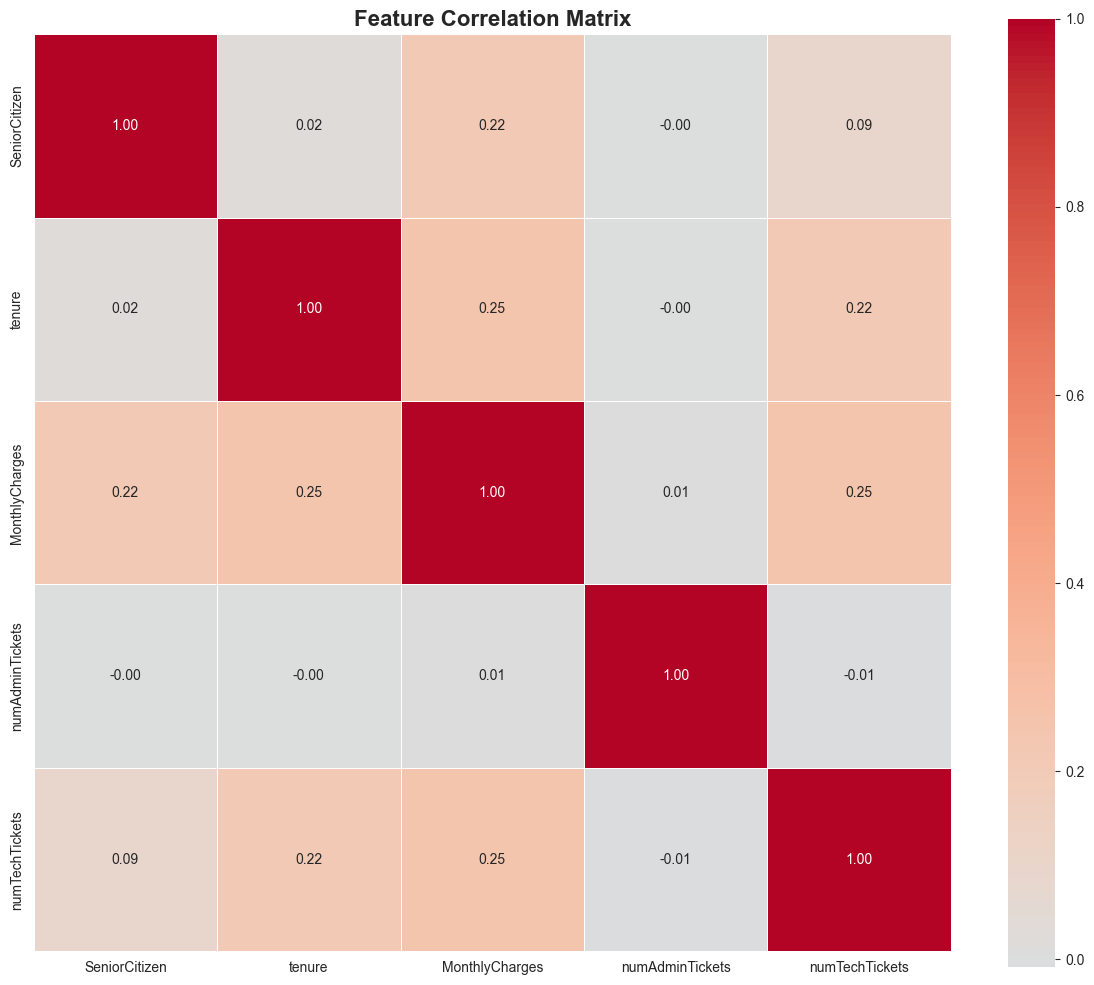


✓ No highly correlated features found


In [20]:
# Correlation matrix for numerical features
if len(numeric_cols) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[numeric_cols].corr()
    
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0, 
                square=True,
                linewidths=0.5)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated features (>0.8)
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                high_corr.append((correlation_matrix.columns[i], 
                                correlation_matrix.columns[j], 
                                correlation_matrix.iloc[i, j]))
    
    if high_corr:
        print("\n⚠️ Highly Correlated Features (|r| > 0.8):")
        for feat1, feat2, corr in high_corr:
            print(f"  {feat1} ↔ {feat2}: {corr:.3f}")
    else:
        print("\n✓ No highly correlated features found")


## 8. Churn vs Numerical Features


### 8.1 Top Correlations with Target


=== Features Most Correlated with Target ===

numTechTickets     0.357283
tenure             0.352229
MonthlyCharges     0.193356
SeniorCitizen      0.150889
numAdminTickets    0.019877
dtype: float64


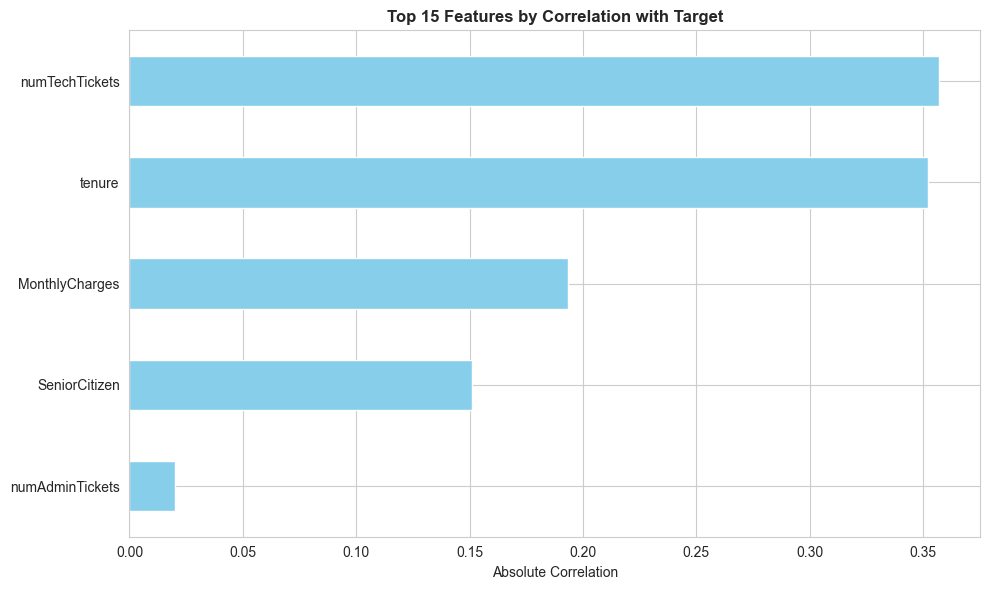

In [21]:
# If target is numeric, show correlations with target
if target_col in df.columns and len(numeric_cols) > 1:
    # Try to encode target if it's categorical
    target_encoded = df[target_col].copy()
    if df[target_col].dtype == 'object':
        # Simple encoding: Yes/No -> 1/0, or use factorize
        if set(df[target_col].unique()).issubset({'Yes', 'No'}):
            target_encoded = (df[target_col] == 'Yes').astype(int)
        else:
            target_encoded = pd.factorize(df[target_col])[0]
    
    # Calculate correlations
    correlations_with_target = df[numeric_cols].corrwith(pd.Series(target_encoded, index=df.index))
    correlations_with_target = correlations_with_target.abs().sort_values(ascending=False)
    
    print("=== Features Most Correlated with Target ===\n")
    print(correlations_with_target.head(10))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    correlations_with_target.head(15).plot(kind='barh', color='skyblue')
    plt.xlabel('Absolute Correlation')
    plt.title('Top 15 Features by Correlation with Target', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


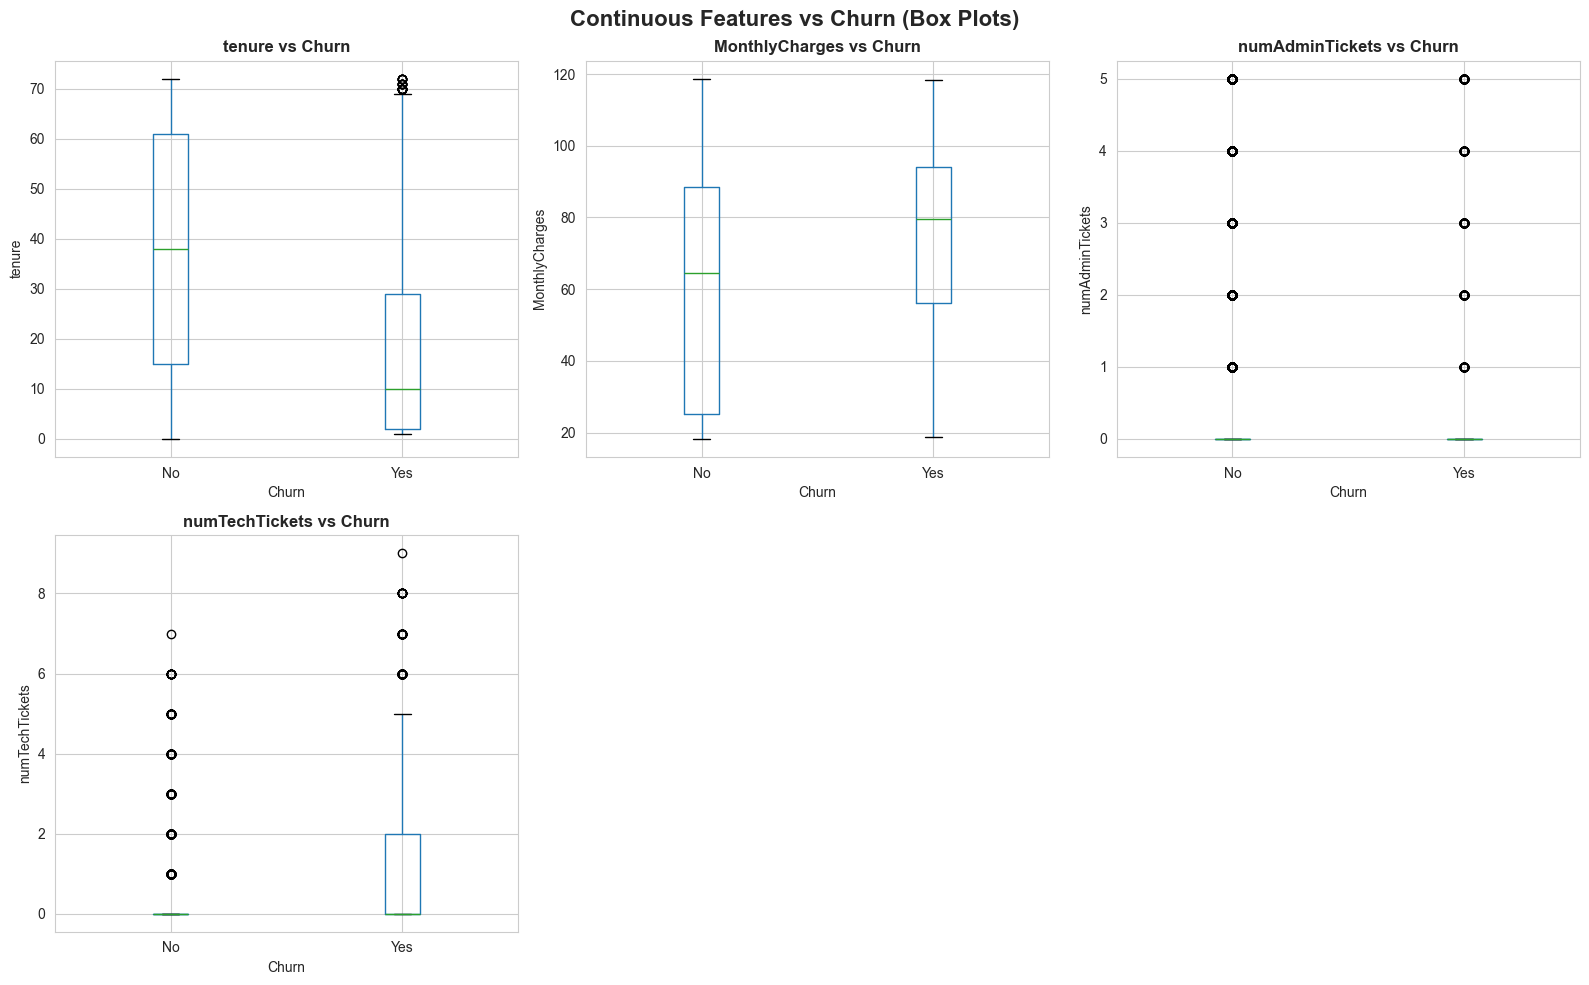


⚠️ NOTE: Binary features excluded from box plots: ['SeniorCitizen']
   Binary features (0/1) don't show meaningful boxes.
   See Section 9 for better visualization of categorical/binary features.

📖 HOW TO INTERPRET THESE BOX PLOTS:

📦 BOX PLOT COMPONENTS:
   • Box = Middle 50% of data (25th to 75th percentile)
   • Line in box = Median (50th percentile)
   • Whiskers = Extend to 1.5 × IQR from box edges
   • Circles (○) = OUTLIERS beyond whiskers

✅ GOOD PREDICTORS - Look for:
   • Medians (middle line) are FAR APART between No/Yes
   • Boxes BARELY OVERLAP
   • Clear visual separation

❌ WEAK PREDICTORS - Look for:
   • Medians are SIMILAR
   • Boxes HEAVILY OVERLAP
   • Hard to tell groups apart

🔴 ABOUT OUTLIERS (circles):
   • Normal to have some outliers
   • Many outliers = High variability in that feature
   • Outliers in one group only = Interesting pattern to investigate
   • Don't panic! They're just flagging unusual cases

🔍 WHAT TO LOOK FOR:
   • Which group has HIGHER me

In [25]:
# Box plots: numerical features vs churn
if target_col in df.columns and len(numeric_cols) > 0:
    # Separate binary from continuous features
    binary_features = [col for col in numeric_cols if df[col].nunique() <= 2]
    continuous_features = [col for col in numeric_cols if df[col].nunique() > 2]
    
    if len(continuous_features) > 0:
        n_features = min(6, len(continuous_features))
        
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        axes = axes.flatten()
        
        for idx, col in enumerate(continuous_features[:n_features]):
            df.boxplot(column=col, by=target_col, ax=axes[idx])
            axes[idx].set_title(f'{col} vs {target_col}', fontweight='bold')
            axes[idx].set_xlabel(target_col)
            axes[idx].set_ylabel(col)
            plt.sca(axes[idx])
            plt.xticks(rotation=0)
        
        # Hide unused subplots
        for idx in range(len(continuous_features[:n_features]), len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle('Continuous Features vs Churn (Box Plots)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Handle binary features separately
    if len(binary_features) > 0:
        print("\n" + "="*70)
        print(f"⚠️ NOTE: Binary features excluded from box plots: {binary_features}")
        print("   Binary features (0/1) don't show meaningful boxes.")
        print("   See Section 9 for better visualization of categorical/binary features.")
        print("="*70)
    
    print("\n" + "="*70)
    print("📖 HOW TO INTERPRET THESE BOX PLOTS:")
    print("="*70)
    print("\n📦 BOX PLOT COMPONENTS:")
    print("   • Box = Middle 50% of data (25th to 75th percentile)")
    print("   • Line in box = Median (50th percentile)")
    print("   • Whiskers = Extend to 1.5 × IQR from box edges")
    print("   • Circles (○) = OUTLIERS beyond whiskers")
    print("\n✅ GOOD PREDICTORS - Look for:")
    print("   • Medians (middle line) are FAR APART between No/Yes")
    print("   • Boxes BARELY OVERLAP")
    print("   • Clear visual separation")
    print("\n❌ WEAK PREDICTORS - Look for:")
    print("   • Medians are SIMILAR")
    print("   • Boxes HEAVILY OVERLAP")
    print("   • Hard to tell groups apart")
    print("\n🔴 ABOUT OUTLIERS (circles):")
    print("   • Normal to have some outliers")
    print("   • Many outliers = High variability in that feature")
    print("   • Outliers in one group only = Interesting pattern to investigate")
    print("   • Don't panic! They're just flagging unusual cases")
    print("\n🔍 WHAT TO LOOK FOR:")
    print("   • Which group has HIGHER median? (look at the line in each box)")
    print("   • Is the difference between medians large or small?")
    print("   • Do the boxes overlap heavily or barely touch?")
    print("\n⚠️ CRITICAL: Don't assume patterns - LOOK at YOUR data!")
    print("   • Check Section 8.2 below for EXACT median values")
    print("   • Let the data tell YOU the story, not your assumptions")
    print("\n💡 WHAT TO DO:")
    print("   • Features with clear separation → Include in model (high priority)")
    print("   • Features with heavy overlap → Consider dropping or combining")
    print("   • Many outliers? Consider: log transform, capping, or robust scaling")
    print("="*70)


### 8.2 Quantitative Analysis of Separation


In [26]:
# Quantify the separation between churners and non-churners
if target_col in df.columns and len(numeric_cols) > 0:
    print("=== Median Comparison: Churners vs Non-Churners ===\n")
    
    comparison_df = pd.DataFrame()
    for col in numeric_cols:
        no_churn_median = df[df[target_col] == 'No'][col].median()
        yes_churn_median = df[df[target_col] == 'Yes'][col].median()
        
        diff = yes_churn_median - no_churn_median
        pct_diff = (diff / no_churn_median * 100) if no_churn_median != 0 else 0
        
        comparison_df = pd.concat([comparison_df, pd.DataFrame({
            'Feature': [col],
            'No Churn (Median)': [no_churn_median],
            'Yes Churn (Median)': [yes_churn_median],
            'Difference': [diff],
            'Pct Diff (%)': [pct_diff]
        })], ignore_index=True)
    
    # Sort by absolute percentage difference
    comparison_df = comparison_df.reindex(
        comparison_df['Pct Diff (%)'].abs().sort_values(ascending=False).index
    )
    
    display(comparison_df)
    
    print("\n" + "="*70)
    print("💡 INTERPRETATION GUIDE:")
    print("="*70)
    print("\n✅ STRONG PREDICTORS (large difference):")
    strong = comparison_df[comparison_df['Pct Diff (%)'].abs() > 30]['Feature'].tolist()
    if strong:
        print(f"   {strong}")
        print("   → These features show CLEAR separation, include them!")
    else:
        print("   None found (no feature with >30% difference)")
    
    print("\n⚠️ MODERATE PREDICTORS (medium difference):")
    moderate = comparison_df[
        (comparison_df['Pct Diff (%)'].abs() > 10) & 
        (comparison_df['Pct Diff (%)'].abs() <= 30)
    ]['Feature'].tolist()
    if moderate:
        print(f"   {moderate}")
        print("   → These features show some separation, keep them")
    else:
        print("   None found")
    
    print("\n❌ WEAK PREDICTORS (small difference):")
    weak = comparison_df[comparison_df['Pct Diff (%)'].abs() <= 10]['Feature'].tolist()
    if weak:
        print(f"   {weak}")
        print("   → Limited separation, may need feature engineering")
    else:
        print("   None found")
    
    print("="*70)


=== Median Comparison: Churners vs Non-Churners ===



,Feature,No Churn (Median),Yes Churn (Median),Difference,Pct Diff (%)
1,tenure,38.000,10.00,-28.000,-73.684211
2,MonthlyCharges,64.425,79.65,15.225,23.632130
0,SeniorCitizen,0.000,0.00,0.000,0.000000
3,numAdminTickets,0.000,0.00,0.000,0.000000
4,numTechTickets,0.000,0.00,0.000,0.000000



💡 INTERPRETATION GUIDE:

✅ STRONG PREDICTORS (large difference):
   ['tenure']
   → These features show CLEAR separation, include them!

⚠️ MODERATE PREDICTORS (medium difference):
   ['MonthlyCharges']
   → These features show some separation, keep them

❌ WEAK PREDICTORS (small difference):
   ['SeniorCitizen', 'numAdminTickets', 'numTechTickets']
   → Limited separation, may need feature engineering


## 9. Churn vs Categorical Features


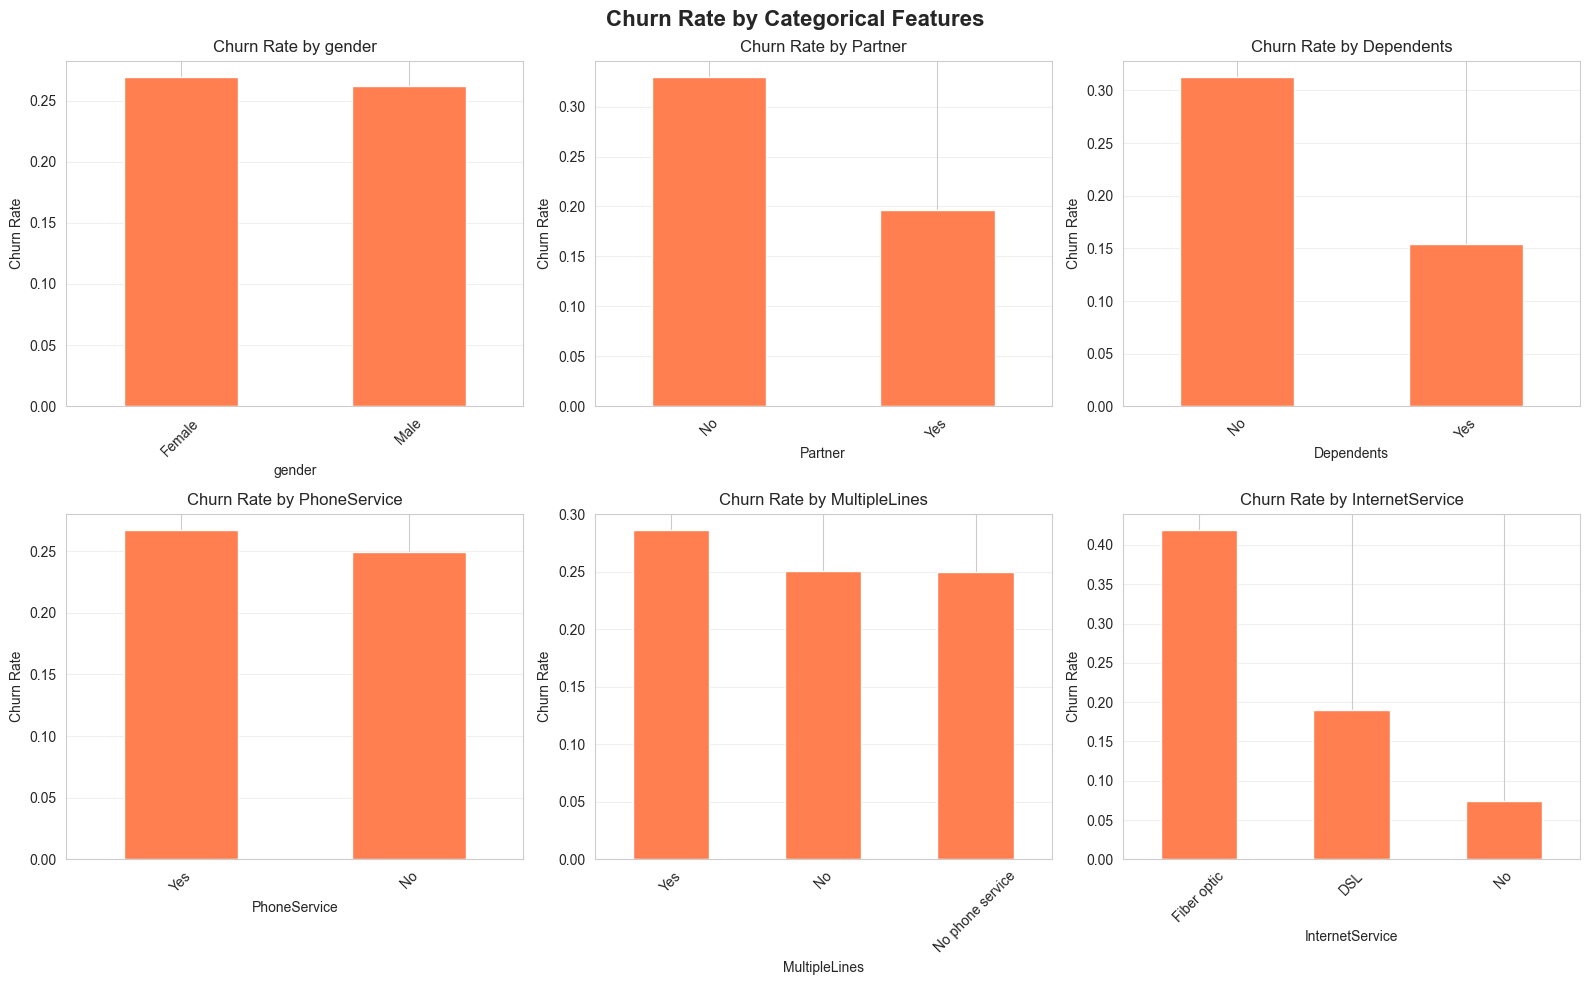

In [27]:
# Churn rate by categorical features
if target_col in df.columns and len(categorical_cols) > 0:
    n_features = min(6, len(categorical_cols))
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(categorical_cols[:n_features]):
        if df[col].nunique() <= 10:  # Only plot if not too many categories
            churn_rate = df.groupby(col)[target_col].apply(
                lambda x: (x == 'Yes').sum() / len(x) if 'Yes' in x.values else x.mean()
            ).sort_values(ascending=False)
            
            churn_rate.plot(kind='bar', ax=axes[idx], color='coral')
            axes[idx].set_title(f'Churn Rate by {col}')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Churn Rate')
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(alpha=0.3, axis='y')
    
    plt.suptitle('Churn Rate by Categorical Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


### 8.1 Statistical Comparison


In [28]:
# Compare means by target class
if target_col in df.columns and len(numeric_cols) > 0:
    print("=== Mean Values by Target Class ===\n")
    
    comparison = df.groupby(target_col)[numeric_cols].mean().T
    comparison['Difference'] = comparison.iloc[:, 1] - comparison.iloc[:, 0]
    comparison['Pct_Diff'] = (comparison['Difference'] / comparison.iloc[:, 0] * 100).round(2)
    comparison = comparison.reindex(comparison['Pct_Diff'].abs().sort_values(ascending=False).index)
    
    display(comparison.head(10))
    
    print("\n💡 Features with largest mean differences may be good predictors")


=== Mean Values by Target Class ===



Churn,No,Yes,Difference,Pct_Diff
numTechTickets,0.151140,1.162654,1.011514,669.25
SeniorCitizen,0.128721,0.254682,0.125961,97.86
tenure,37.569965,17.979133,-19.590832,-52.14
MonthlyCharges,61.265124,74.441332,13.176209,21.51
numAdminTickets,0.530924,0.473515,-0.057409,-10.81



💡 Features with largest mean differences may be good predictors


### 10.1 Outlier Statistics


In [29]:
# Calculate outliers using IQR method
if len(numeric_cols) > 0:
    print("=== Outlier Count (IQR Method) ===\n")
    
    outlier_summary = []
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df)) * 100
        
        outlier_summary.append({
            'Feature': col,
            'Outlier Count': outlier_count,
            'Percentage': f"{outlier_pct:.2f}%",
            'Lower Bound': f"{lower_bound:.2f}",
            'Upper Bound': f"{upper_bound:.2f}"
        })
    
    outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier Count', ascending=False)
    display(outlier_df)
    
    high_outliers = outlier_df[outlier_df['Outlier Count'] > len(df) * 0.05]['Feature'].tolist()
    if high_outliers:
        print(f"\n⚠️ Features with >5% outliers: {high_outliers}")
        print("Consider: Capping (winsorization), log transformation, or investigation")


=== Outlier Count (IQR Method) ===



,Feature,Outlier Count,Percentage,Lower Bound,Upper Bound
3,numAdminTickets,1201,17.05%,0.00,0.00
0,SeniorCitizen,1142,16.21%,0.00,0.00
4,numTechTickets,970,13.77%,0.00,0.00
1,tenure,0,0.00%,-60.00,124.00
2,MonthlyCharges,0,0.00%,-46.02,171.38



⚠️ Features with >5% outliers: ['numAdminTickets', 'SeniorCitizen', 'numTechTickets']
Consider: Capping (winsorization), log transformation, or investigation


## 10. Outlier Detection


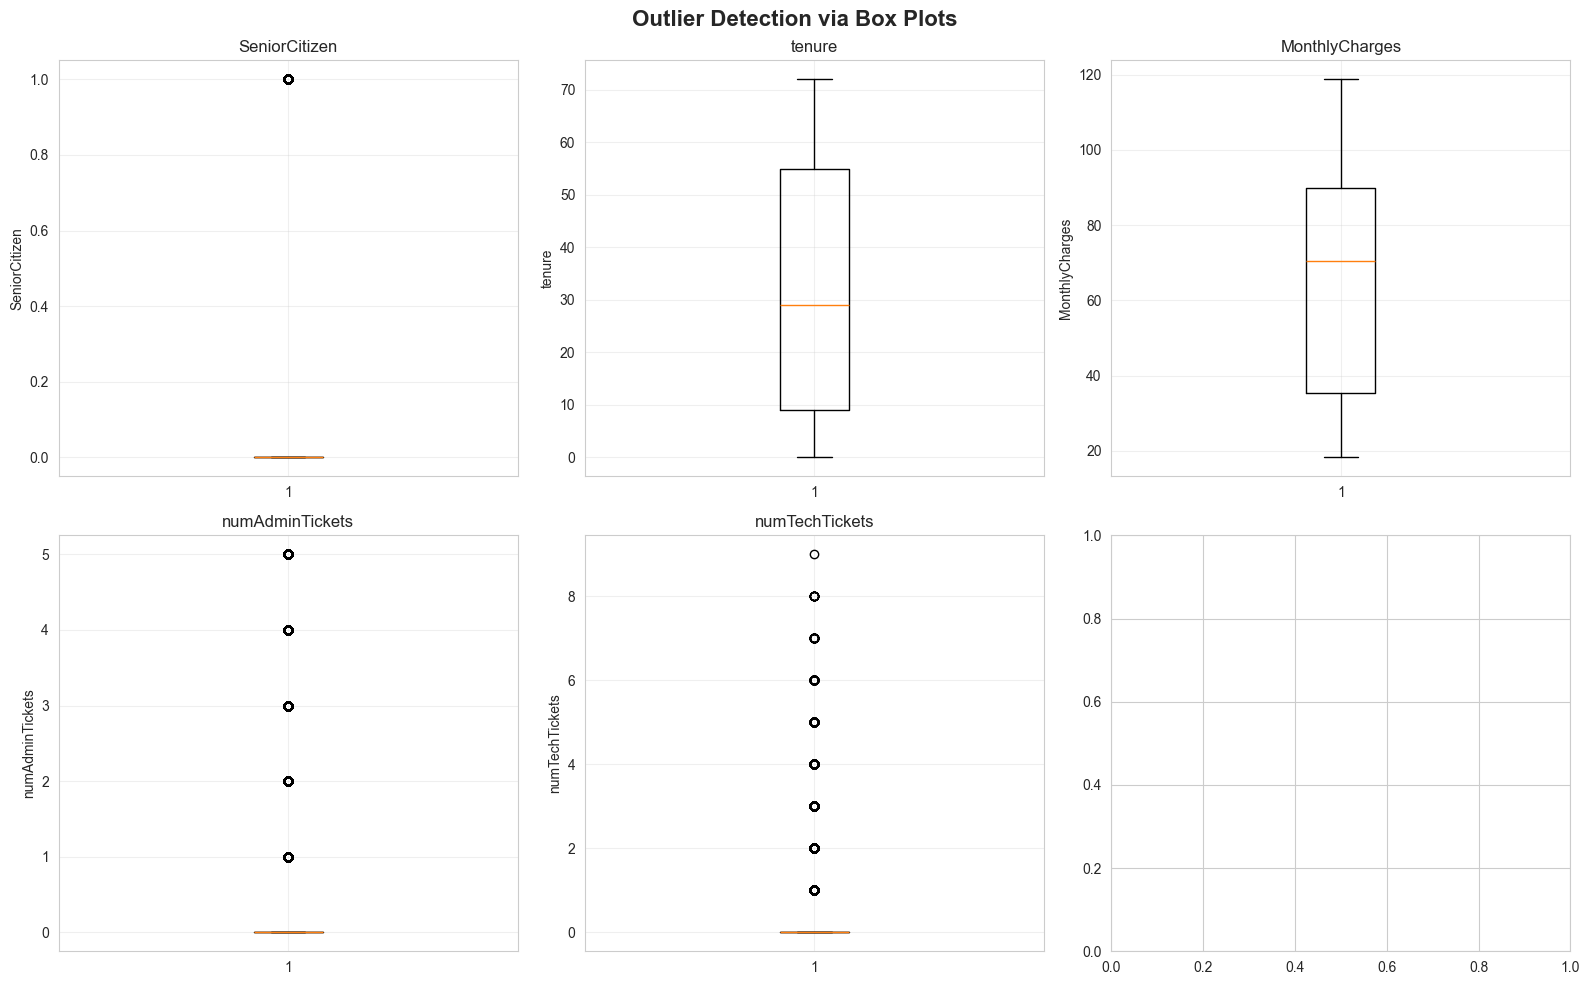

In [30]:
# Box plots for outlier detection
if len(numeric_cols) > 0:
    n_features = min(6, len(numeric_cols))
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols[:n_features]):
        axes[idx].boxplot(df[col].dropna())
        axes[idx].set_title(f'{col}')
        axes[idx].set_ylabel(col)
        axes[idx].grid(alpha=0.3)
    
    plt.suptitle('Outlier Detection via Box Plots', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 11. Key Findings Summary


### 11.1 Statistical Significance


In [31]:
# Chi-square test for categorical features
from scipy.stats import chi2_contingency

if target_col in df.columns and len(categorical_cols) > 0:
    print("=== Chi-Square Test: Categorical Features vs Target ===\n")
    
    chi_square_results = []
    for col in categorical_cols[:10]:  # Limit to first 10
        if df[col].nunique() <= 20:  # Only test if reasonable number of categories
            contingency_table = pd.crosstab(df[col], df[target_col])
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            
            chi_square_results.append({
                'Feature': col,
                'Chi2': chi2,
                'P-Value': p_value,
                'Significant': '✓' if p_value < 0.05 else '✗'
            })
    
    if chi_square_results:
        chi_df = pd.DataFrame(chi_square_results).sort_values('P-Value')
        display(chi_df)
        
        significant_features = chi_df[chi_df['P-Value'] < 0.05]['Feature'].tolist()
        print(f"\n💡 Statistically significant features (p < 0.05): {len(significant_features)}")
        print(f"   {significant_features}")


=== Chi-Square Test: Categorical Features vs Target ===



,Feature,Chi2,P-Value,Significant
6,OnlineSecurity,849.998968,2.661150e-185,✓
9,TechSupport,828.197068,1.443084e-180,✓
5,InternetService,732.309590,9.571788e-160,✓
7,OnlineBackup,601.812790,2.079759e-131,✓
8,DeviceProtection,558.419369,5.505219e-122,✓
2,Dependents,189.129249,4.924922e-43,✓
1,Partner,158.733382,2.139911e-36,✓
4,MultipleLines,11.330441,3.464383e-03,✓
3,PhoneService,0.915033,3.387825e-01,✗
0,gender,0.484083,4.865787e-01,✗



💡 Statistically significant features (p < 0.05): 8
   ['OnlineSecurity', 'TechSupport', 'InternetService', 'OnlineBackup', 'DeviceProtection', 'Dependents', 'Partner', 'MultipleLines']


### 📊 Summary & Action Plan

Fill in after running all cells above:

**✅ Data Quality:**
- Total rows: ___
- Missing values: ___
- Duplicates: ___

**🎯 Target Variable:**
- Distribution: ___
- Imbalance ratio: ___:1
- Baseline accuracy: ___%

**📊 Top 5 Predictive Features:**
1. ___
2. ___
3. ___
4. ___
5. ___

**🔧 Preprocessing Plan:**
- Missing values: ___
- Outliers: ___
- Encoding: ___
- Scaling: ___
- Class imbalance: ___

**🚫 Features to Drop:**
- ___ (reason: ___)

**🚀 Next Steps:**
1. [ ] Run data pipeline: `python src/pipeline.py`
2. [ ] Train baseline model
3. [ ] Track in MLflow

**💡 Key Insights:**
- ___
- ___
- ___

**Data Quality:**
- [ ] Missing values: [describe]
- [ ] Duplicates: [check]
- [ ] Data types: [correct/needs fixing]

**Target Variable:**
- [ ] Class imbalance: [percentage]
- [ ] Action needed: [balancing strategy if needed]

**Features:**
- [ ] Most correlated with churn: [list top 3-5]
- [ ] Highly correlated features: [list pairs to consider removing]
- [ ] Outliers: [significant outliers found in which features?]

**Next Steps:**
1. [ ] Handle missing values (strategy: ___)
2. [ ] Feature engineering ideas: [list]
3. [ ] Features to drop: [list with reasons]
4. [ ] Encoding strategy: [one-hot, label, etc.]
5. [ ] Scaling needed: [yes/no, which features]
